<div class="alert alert-block alert-info">
    <img style="float: right;" src="https://raw.githubusercontent.com/OpenSourceEconomics/ose-corporate-design/master/logos/OSE_logo_RGB.svg" width="150">
    <u><h1>respy Showcase</h1></u>
</div>

### What is **respy**?

**respy** is an open source framework written in Python for the simulation and estimation of some finite-horizon discrete choice dynamic programming models. The group of models which can be currently represented in **respy** are called Eckstein-Keane-Wolpin models.

### Where do I find more information?

**GitHub:** The source code is available at https://github.com/OpenSourceEconomics/respy.

**Online Documentation:** The online documentation with tutorials, guides, and more is available at https://respy.readthedocs.io.

**Lectures:** Lectures on selected topics like Maximum Likilhood estimation using **respy** can be found here: https://ekw-lectures.readthedocs.io.

### Why should I use the package?

What makes **respy** powerful is that it allows to build and solve structural models in weeks or months whose development usually takes years. 

### Outline

The upcoming tutorial provides an example on how you can utilize **respy** to set up your own model. As an example, we implement a Robinson Crusoe economy as a discrete choice dynamic programming model. The tutorial is structured as follows:

 1.  Installation  
 2.  Introductory Tutorial  
  2.1. Theoretical Framework  
  2.2. Specifying a Model in Respy  
  2.3. Simulating Data  
  2.4. Extending the Model  
 3. Example Models in respy
 4. Further and upcoming functionalities in respy and other OpenSourceEconomics packages
    

<div class="alert alert-block alert-info">
    <u><h2>1. Installation</h2></u>
</div>

The package can be installed via conda as follows

```
$ conda config --add channels conda-forge
$ conda install -c opensourceeconomics respy
```

After doing so, you can import respy alongside all other packages you are using.

In [5]:
import io
import copy
import yaml
import numpy as np
import pandas as pd
import respy as rp
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image
from pathlib import Path

from auxiliary.auxiliary import *

<div class="alert alert-block alert-info">
    <u><h1>2. Introductory Tutorial</h1></u>
</div>

<div class="alert alert-block alert-info">
    <u><h2>2.1. Theoretical Framework: Robinson Crusoe on an island</h2></u>
</div>

> After setting sail against his parents' wishes, being captured by pirates, escaping from them, building a plantation, and setting sail again, [Robinson Crusoe](https://en.wikipedia.org/wiki/Robinson_Crusoe) stranded on a small island. He is alone with one dog, two cats, and only some supplies. He goes fishing to make ends meet and if he is too tired he will relax in his hammock. But, he cannot relax to often as storing food is a difficult task on a tropical island.


Summarizing this economic problem:

- Robinson chooses every period $t = 0, \dots, T$ to either go fishing, $a = 0$, or spend the day in the hammock, $a = 1$.

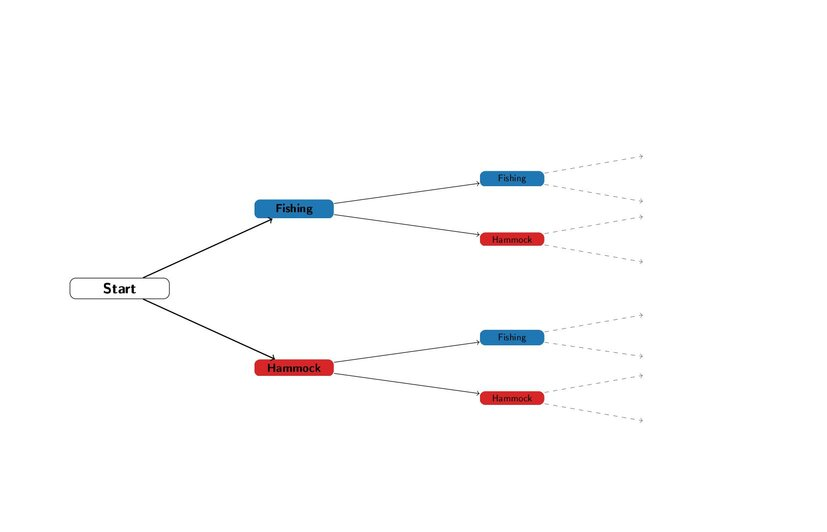

In [6]:
Image(filename="figures/tree_small.jpg")

- If Robinson chooses to go fishing, he gains one additional unit of experience in the next period. Experience starts at zero.

- The utility of a choice, $U(s_t, a_t)$, depends on the state $s_t$, which contains information on the individual's characteristics, and the chosen alternative $a_t$.

- Robinson's utility for any given option can be denoted by

$$\begin{align}
    U(s_t, a_t) = \underbrace{W(s_t, a_t)}_{wage} + \underbrace{N(s_t, a_t)}_{non-pecuniary}
\end{align}
$$

**Working alternatives**

- For working alternatives like fishing, utility consists of two components, a wage and a non-pecuniary component. The wage is defined as 

$$\begin{align}
        W(s_t, a_t)  &= r_a \exp\{x^w_{at} \beta^w_a + \epsilon_{at}\}\\
    \ln(W(s_t, a_t)) &= \ln(r_a) + x^w_{at} \beta^w_a + \epsilon_{at}
\end{align}$$

- It consists of several components:
    - $r_a$ is a market rental price for skill units.
    - $x^w_{at}$ and $\beta^w_a$ are the choice- and time-dependent covariates and returns related to the wage signaled by superscript $w$. 
    - $\epsilon_{at}$ is a choice-specific random shock from the shock vector $\epsilon_t \sim \mathcal{N}(0, \Sigma)$ for all choices.

- The non-pecuniary rewards for working alternatives are a vector dot product of covariates $x_t^w$ and parameters $\beta^w$. The superscript $w$ signals that the components belong to working alternatives.

$$\begin{align}
    N^w(s_t, a_t) = x_t^w\beta^w
\end{align}$$

**Non-working alternatives**

- For non-working alternatives like the hammock, $W(s_t, a_t) = 0$. The non-pecuniary reward for non-working alternatives is very similar to the working alternative except that the shocks enter the equation additively. Superscript $n$ stands for non-pecuniary.

$$
    N^n(s_t, a_t) = x_t^n\beta^n + \epsilon_{at}
$$


- Robinson's choice set thus consists of a "working" alternative which awards him a pecuniary compensation or wage and a "leisure" or non-working alternative which he derives a utility from, but no experience or wage. Experience in this basic model starts at zero and increases by one for every period $t$ in $1, ..., T$ where he chooses to go fishing. 


**Robinson's choice problem**

- During his time on the island, Robinson has to make choices about which actions to take. The general assumption is that Robinson is forward-looking and maximizes the expected present value of utility over the remaining lifetime which is achieved by selecting the optimal sequence of choices $\{a_t\}^T_{t = 0}$.


- Robinsons decision problem can be expressed as a Bellman equation where the value of a given state consists of the current and future state values associated with it.  

$$\begin{align}
    V(s_{t})&= \max_{a_t} \, \{\underbrace{U(s_t, a_t)}_{\text{flow utility}}+ \delta \underbrace{\text{E}[ V(s_{t+1})]\}}_{\text{continuation value}}
\end{align}$$

- For each period, the value of a given choice consists of its flow utility and its continuation value. Since the realization of shocks becomes known in each period before Robinson makes his choice, the flow utility can be extracted from the expectation operator. As shocks in period $t + 1$ are unknown to the individual in period $t$, utility must be maximized given the joint distribution of shocks in period $t + 1$ which is a maximization problem over a two-dimensional integral. Denote the non-stochastic part of a state as $s^-$. Then, Robinson maximizes

$$\begin{equation}
    V(s_t) = \max_{a_t}\{
        U(s_t, a_t) + \delta \int_{\epsilon_{1, t + 1}} \int_{\epsilon_{0, t + 1}}
        \max_{a_{t + 1}} V_{a_{t + 1}}(s^-_{t + 1}, \epsilon_{t + 1})
        f_\epsilon(\epsilon_{t + 1})
        d_{\epsilon_{0, t + 1}}, d_{\epsilon_{1, t + 1}}
    \}
\end{equation}$$

<div class="alert alert-block alert-info">
    <u><h2>2.2. Specifying the Model in respy</h2></u>
</div>

We can use **respy** to implement the model specified above. In order to process a model, **respy** requires two main inputs: `params` and `options`.


### params

The `params` object acts as the parameter vector of the model. Most of its values translate directly to parameters you can see in the equations. 

Parameters are specified as a [MultiIndex pandas.DataFrame](https://pandas.pydata.org/pandas-docs/stable/user_guide/advanced.html) with two index levels. A *category* which indicates certain parameters groups and a *name* which indicates a specific parameter. There are certain naming conventions in place that help **respy** recognize different parameters of the model.

We can read in parameters from a .csv-file. Here we define the parameter data in a string format to showcase the specification. Usually, the more convenient way would be to specify the parameters outside this notebook and to just import them from a separate file.

In [7]:
params = """category,name,value
delta,delta,0.95
wage_fishing,exp_fishing,0.1
nonpec_fishing,constant,-1
nonpec_hammock,constant,2.5
nonpec_hammock,not_fishing_last_period,-1
shocks_sdcorr,sd_fishing,1
shocks_sdcorr,sd_hammock,1
shocks_sdcorr,corr_hammock_fishing,-0.2
lagged_choice_1_hammock,constant,1
"""

In [8]:
params_basic = pd.read_csv(
    io.StringIO(params), sep=",", index_col=["category", "name"]
)

In [9]:
params_basic

value
category                name                          
delta                   delta                     0.95
wage_fishing            exp_fishing               0.10
nonpec_fishing          constant                 -1.00
nonpec_hammock          constant                  2.50
                        not_fishing_last_period  -1.00
shocks_sdcorr           sd_fishing                1.00
                        sd_hammock                1.00
                        corr_hammock_fishing     -0.20
lagged_choice_1_hammock constant                  1.00

### options

The second object required to set up a model are the `options`. The are specified as a dictionary which contains additional information like the number of periods in the model or the size of the simulated sample.

In [10]:
options_basic = {
    "n_periods": 10,
    "simulation_agents": 1000,
    "simulation_seed": 123,
    "covariates": {
        "constant": "1",
        "not_fishing_last_period": "lagged_choice_1 != 'fishing'",
    },
}

In [11]:
options_basic

{'n_periods': 10,
 'simulation_agents': 1000,
 'simulation_seed': 123,
 'covariates': {'constant': '1',
  'not_fishing_last_period': "lagged_choice_1 != 'fishing'"}}

<div class="alert alert-block alert-info">
    <u><h2>2.3. Simulating Data</h2></u>
</div>

Using the `params` and `options` we can set up a simulator using the function `get_simulate_func` and subsequently simulate a data for our selected parametrization.

In [12]:
simulate = rp.get_simulate_func(params_basic, options_basic)
df_basic = simulate(params_basic)

In [13]:
df_basic.head(5)

Experience_Fishing Lagged_Choice_1  Shock_Reward_Fishing  \
Identifier Period                                                             
0          0                        0         hammock              0.428556   
           1                        1         fishing              0.780145   
           2                        1         hammock              2.063393   
           3                        2         fishing             -1.190336   
           4                        3         fishing             -0.049084   

                   Meas_Error_Wage_Fishing  Shock_Reward_Hammock  \
Identifier Period                                                  
0          0                             1              0.427466   
           1                             1              1.850937   
           2                             1              0.708209   
           3                             1             -2.028002   
           4                             1              0.607816   

                   Meas_Error_Wage_Hammock  Dense_Key  Core_Index   Choice  \
Identifier Period                                                            
0          0                             1          0           1  fishing   
           1                             1          1           0  hammock   
           2                             1          2           0  fishing   
           3                             1          3           4  fishing   
           4                             1          4           5  hammock   

                       Wage  ...  Nonpecuniary_Reward_Fishing  Wage_Fishing  \
Identifier Period            ...                                              
0          0       1.535039  ...                           -1      1.535039   
           1            NaN  ...                           -1      2.411250   
           2       8.700606  ...                           -1      8.700606   
           3       0.371452  ...                           -1      0.371452   
           4            NaN  ...                           -1      1.285202   

                   Flow_Utility_Fishing  Value_Function_Fishing  \
Identifier Period                                                 
0          0                   0.535039               19.006626   
           1                   1.411250               19.104983   
           2                   7.700606               23.415469   
           3                  -0.628548               13.904880   
           4                   0.285202               13.405278   

                   Continuation_Value_Fishing  Nonpecuniary_Reward_Hammock  \
Identifier Period                                                            
0          0                        19.443776                          1.5   
           1                        18.624982                          2.5   
           2                        16.541961                          1.5   
           3                        15.298346                          2.5   
           4                        13.810606                          2.5   

                   Wage_Hammock  Flow_Utility_Hammock  Value_Function_Hammock  \
Identifier Period                                                               
0          0                NaN              1.833118               18.704274   
           1                NaN              4.157512               20.273393   
           2                NaN              1.781221               16.030649   
           3                NaN              0.751039               13.874853   
           4                NaN              3.105353               14.884157   

                   Continuation_Value_Hammock  
Identifier Period                              
0          0                        17.759111  
           1                        16.964086  
           2                        14.999397  
           3                        13.814541  
           4  

Using our simulated data, we can now inspect the choices of Robinson.

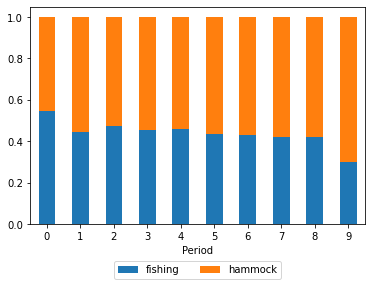

In [14]:
plot_choice_shares(df_basic)

Inspecting the persistence in choices shows that Robinson rarely chooses the same option multiple times in a row.

<AxesSubplot:xlabel='Choice', ylabel='Lagged_Choice_1'>

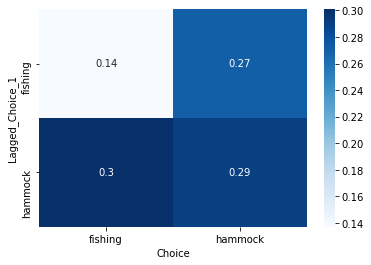

In [15]:
data = pd.crosstab(df_basic.Lagged_Choice_1, df_basic.Choice, normalize=True)
sns.heatmap(data, cmap="Blues", annot=True)

<div class="alert alert-block alert-info">
    <u><h2>2.4. Extending the Model</h2></u>
</div>

As already stated in the introduction, one of the main advantages of **respy** is that the package is flexible regarding the model structure. We will illustrate this by extending the previously introduced model framework in several different ways.

<div class="alert alert-block alert-info">
    <u><h3>2.4.1. Extension: Covariates</h3></u>
</div>

Next we want to add a covariate. As before, we concentrate on a simple example, but this can be extended in any direction. Note, that in the basic model we had two covariates: 

1. The constant, which is the simplest covariate
2. The indicator whether Robinson went fishing last period.

Covariates allow to specify advanced return structures to each choice. In the following example, Robinson's return to fishing decreases as he gets older. We assume that he arrives at the island with 16 years. Then his age in each period, which we assume for now is one year, increases by one. So in each period his age is given by `period + 16`. We define the covariate and his value in each period in the option file.

In [16]:
options_age = copy.deepcopy(options_basic)
options_age["covariates"].update({"age": "period + 16"})
options_age

{'n_periods': 10,
 'simulation_agents': 1000,
 'simulation_seed': 123,
 'covariates': {'constant': '1',
  'not_fishing_last_period': "lagged_choice_1 != 'fishing'",
  'age': 'period + 16'}}

In a second step, we specify the return for the choice for this covariate.

In [17]:
params_age = params_basic.copy()
params_age.loc[("wage_fishing", "age"), "value"] = -0.015
params_age

value
category                name                          
delta                   delta                    0.950
wage_fishing            exp_fishing              0.100
nonpec_fishing          constant                -1.000
nonpec_hammock          constant                 2.500
                        not_fishing_last_period -1.000
shocks_sdcorr           sd_fishing               1.000
                        sd_hammock               1.000
                        corr_hammock_fishing    -0.200
lagged_choice_1_hammock constant                 1.000
wage_fishing            age                     -0.015

Having adjusted the parameters and options accordingly, we can now simulate data that incorporates the new age covariate. As the plot below shows, including the negative effect of age reduces the proportion of individuals that choose fishing, increasingly so in later periods.

In [18]:
simulate = rp.get_simulate_func(params_age, options_age)
df_age = simulate(params_age)

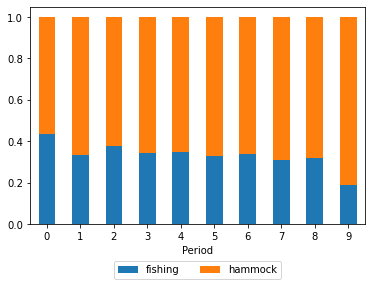

In [19]:
plot_choice_shares(df_age)

<div class="alert alert-block alert-info">
    <u><h3>2.4.2. Extension: Adding Choices</h3></u>
</div>

Lets return to the basic example and alter the choice set of Robinson. Let's assume after some time on the island, Robinson meets Friday we can help him improve his fishing.

We thus add the option `"friday"`, which affects the utility of fishing. The choice should be available only once starting with the third period, and only after Robinson has been fishing before. As a first step, we need to alter the parameter vector. Here we just import a pre-defined parameter vector from a .csv-file. There have been three main changes to the base parameter vector:

1. `wage_fishing` now includes a return to contemplation with Friday.
2. There is a new category,`nonpec_friday`, which captures the non-pecuniary reward for of spending a period with Friday. Since talking to Friday is purely non-pecuniary option, Robinson does not earn a wage when choosing it.
3. The shock shock variance-covariance matrix has been altered to include the additional option. 


In [20]:
params_friday = pd.read_csv(
    "params_files/robinson_crusoe_friday.csv", index_col=["category", "name"]
)
params_friday

value
category                name                            
delta                   delta                       0.95
wage_fishing            exp_fishing                 0.10
                        contemplation_with_friday   0.40
nonpec_fishing          constant                   -1.00
nonpec_friday           constant                   -1.00
                        not_fishing_last_period    -1.00
nonpec_hammock          constant                    2.50
                        not_fishing_last_period    -1.00
shocks_sdcorr           sd_fishing                  1.00
                        sd_friday                   1.00
                        sd_hammock                  1.00
                        corr_friday_fishing         0.00
                        corr_hammock_fishing        0.00
                        corr_hammock_friday         0.00
lagged_choice_1_hammock constant                    1.00

Turning to the `options`, we can see that the new covariate `"contemplation_with_friday"` is only affecting utility if Robinson is experienced in fishing and only for one interaction with Friday. This naturally limits the interaction with Friday.

In [21]:
options_friday = yaml.safe_load(open("option_files/options_friday.yml"))
options_friday["covariates"]

{'constant': '1',
 'contemplation_with_friday': 'exp_friday == 1 and exp_fishing >= 1',
 'not_fishing_last_period': "lagged_choice_1 != 'fishing'"}

The key `"negative_choice_set"` can be used to restrict the choice Friday to the third and following periods. The first key matches a choice. 

In [22]:
options_friday["negative_choice_set"]

{'friday': ['period < 2', 'exp_fishing == 0']}

We additionally need to define `core_state_space_filters` now that we added Friday. They are specified as a list of strings that define certain events which shall be avoided. If the string evaluates to `True` for a potential state, the corresponding state is eliminated from the core state space. These options thus compliment the `negative_choice_set`. 

Some states are impossible from a model perspective, but eliminating them using the `core_state_space_filters` is still worthwhile to eliminate them to ease the computational burden of the model. See for instance the string `"period > 0 and exp_fishing + exp_friday == period and lagged_choice_1 == 'hammock'"`. This expression  essentially states hat whenever individuals accumulated as many years of experience as there are periods, the previous choice cannot be a choice without experience accumulation. This seems trivial, but states for which this expression evaluates to `True` will still be included in the state space if we do not eliminate them using the filters.

In [23]:
options_friday["core_state_space_filters"]

["period > 0 and exp_fishing + exp_friday == period and lagged_choice_1 == 'hammock'",
 'period <= 2 and exp_friday != 0',
 'period >= 3 and period - exp_friday < 2',
 'exp_friday > 0 and exp_fishing == 0',
 "exp_friday > 0 and exp_fishing == 1 and lagged_choice_1 == 'fishing'",
 "period - exp_friday == 2 and lagged_choice_1 != 'friday' and period > 2",
 "exp_{choices_w_exp} == 0 and lagged_choice_1 == '{choices_w_exp}'"]

We can now simulate our new model including Friday.

In [24]:
simulate = rp.get_simulate_func(params_friday, options_friday)
df_friday = simulate(params_friday)

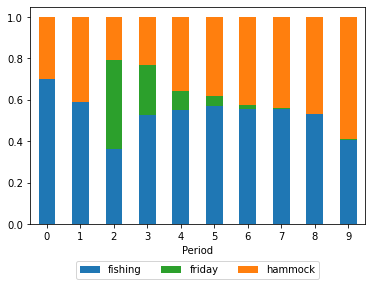

In [25]:
plot_choice_shares(df_friday, friday=True)

<div class="alert alert-block alert-info">
    <u><h3>2.4.3. Extension: Initial Experience</h3></u>
</div>

Again returning to the basic example, we will next demonstrate how to include heterogeneity in initial conditions in `respy`: In period $t=0$, Robinson will have $0$, $1$, or $2$ periods of experience in fishing. We can thus analyze what happens to Robinson's choices if he lands on the island with previous experience in fishing attained before being stranded.

To allow Robinson to have nonzero experience in fishing in the first period, we need to modify `params`: We specify the distribution of initial experience via **probability mass functions**, as the probabilities do not depend on any information. 
The keyword is `"initial_exp_fishing_*"` in the category-level of the index, where the asterisk needs to be replaced with the experience level. In the name-level, use `"probability"` to signal that the float in `"value"` is a probability. 

The new parameter specification is below: Robinson has equal probability to start out with 0, 1 or 2 periods of experience. However, one probability is set to 0.34 so that all probabilities sum to one. If that is not the case, `respy` will emit a warning and normalize probabilities to a uniform distribution.

In [26]:
params_initial_exp = params_basic.copy()
params_initial_exp.loc[
    ("initial_exp_fishing_0", "probability"), "value"
] = 0.33
params_initial_exp.loc[
    ("initial_exp_fishing_1", "probability"), "value"
] = 0.33
params_initial_exp.loc[
    ("initial_exp_fishing_2", "probability"), "value"
] = 0.34
params_initial_exp

value
category                name                          
delta                   delta                     0.95
wage_fishing            exp_fishing               0.10
nonpec_fishing          constant                 -1.00
nonpec_hammock          constant                  2.50
                        not_fishing_last_period  -1.00
shocks_sdcorr           sd_fishing                1.00
                        sd_hammock                1.00
                        corr_hammock_fishing     -0.20
lagged_choice_1_hammock constant                  1.00
initial_exp_fishing_0   probability               0.33
initial_exp_fishing_1   probability               0.33
initial_exp_fishing_2   probability               0.34

In [23]:
simulate = rp.get_simulate_func(params_initial_exp, options_basic)
df_exp = simulate(params_initial_exp)

We can the plot the choice frequencies for both scenarios to compare Robinson's actions.

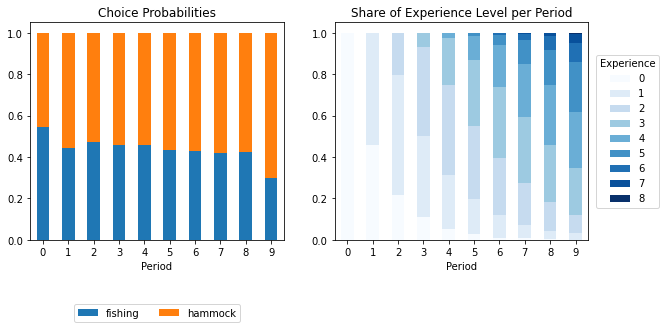

In [24]:
plot_choice_prob_and_exp_level(df_basic)

Comparing the plots shows that the share of engagement in fishing increases compared to the baseline scenario, as two thirds of Robinsons land on the island with previous experience in fishing. 

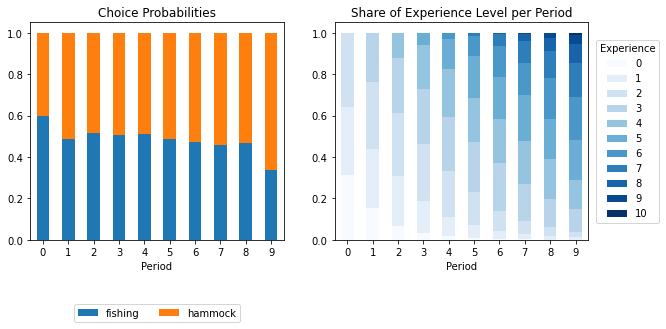

In [25]:
plot_choice_prob_and_exp_level(df_exp)

<div class="alert alert-block alert-info">
    <u><h3>2.4.4. Extension: Observables</h3></u>
</div>

Next add one observable characteristic to the baseline model, `"Fishing_Grounds"`: Now Robinson can end up, with a certain probability, on the side of the island which has `"poor"` or `"rich"` fishing grounds. Experiencing rich fishing grounds affects the **non-pecuniary reward** for fishing. 

To specify the observable, we add three additional rows to `params`:

- The probability with which Robinson will find himself in rich and in poor fishing grounds;

- The return for being in a rich fishing ground, which here is set to be positive and constant.

`respy` allows for complex probability distributions of observables, which may for instance depend on other covariates. However, we will assume that the observable's probability distribution does not depend on any other information. We assume that each Robinson is randomly assigned to a certain side of the island, according to the float specified under value in the name-level probability.

Note that all probabilities sum to one. If that is not the case, **respy** will emit a warning and normalize probabilities.

In [26]:
params_fish_ground = params_basic.copy()
params_fish_ground.loc[
    ("observable_fishing_grounds_rich", "probability"), "value"
] = 0.5
params_fish_ground.loc[
    ("observable_fishing_grounds_poor", "probability"), "value"
] = 0.5
params_fish_ground.loc[
    ("nonpec_fishing", "rich_fishing_grounds"), "value"
] = 0.5
params_fish_ground

value
category                        name                          
delta                           delta                     0.95
wage_fishing                    exp_fishing               0.10
nonpec_fishing                  constant                 -1.00
nonpec_hammock                  constant                  2.50
                                not_fishing_last_period  -1.00
shocks_sdcorr                   sd_fishing                1.00
                                sd_hammock                1.00
                                corr_hammock_fishing     -0.20
lagged_choice_1_hammock         constant                  1.00
observable_fishing_grounds_rich probability               0.50
observable_fishing_grounds_poor probability               0.50
nonpec_fishing                  rich_fishing_grounds      0.50

We also need to overwrite the covariates section of `options` to include which level of the observable is associated with a higher nonpecuniary reward for fishing:

In [27]:
options_fish_ground = options_basic.copy()
options_fish_ground["covariates"] = {
    "constant": "1",
    "not_fishing_last_period": "lagged_choice_1 != 'fishing'",
    "rich_fishing_grounds": "fishing_grounds == 'rich'",
}
options_fish_ground

{'n_periods': 10,
 'simulation_agents': 1000,
 'simulation_seed': 123,
 'covariates': {'constant': '1',
  'not_fishing_last_period': "lagged_choice_1 != 'fishing'",
  'rich_fishing_grounds': "fishing_grounds == 'rich'"}}

In [28]:
simulate = rp.get_simulate_func(params_fish_ground, options_fish_ground)
df_fish_ground = simulate(params_fish_ground)

As can be expected, Robinson engages in fishing more often if he is stranded on the side of the island with rich fishing grounds.

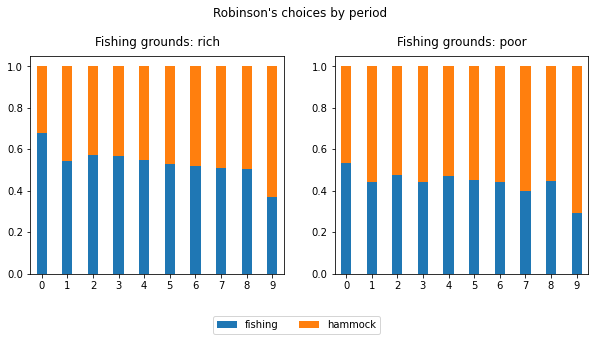

In [29]:
plot_fishing_grounds(df_fish_ground)

<div class="alert alert-block alert-info">
    <u><h2>3. Example Models in respy</h2></u>
</div>

The story of Robinson is an illustrative introductory example to `respy`'s modeling capabilities. What may not be evident at first sight, is that it in this context is a story of human capital accumulation which constitutes a central topic in economic research. `respy` is designed to be used for much larger and more complex models that are capable of addressing real world policy questions and are calibrated to empirical data. To illustrate the scalability of `respy` models, the interface includes a number of example models that are taken from actual economic publications.

They can be accessed as ```params, options, data = rp.get_example_model(<model>)```

Below are the example models that are currently available. 

### Toy models

The package provides users with two toy models. These models can be used to acquaintance oneself with **respy**'s functionalities and can be encountered in the [tutorials](https://respy.readthedocs.io/en/latest/tutorials/index.html) in the documentation. The models are called:

- `robinson_crusoe_basic`
- `robinson_crusoe_extended`

We have gotten to know the toy models in this tutorial: we started off with a version of the most basic model in which has Robinson either fishing or relaxing in the hammock and, amongst other things, extended the model to `robinson_crusoe_extended` where he can additionally talk to Friday to improve his fishing.

These models are excellent examples to use for learning and prototyping because they are very computationally feasible due to the small number of available choices and low number of periods in the models.

#### Basic Robinson Model

In [30]:
_, _, data = rp.get_example_model("robinson_crusoe_basic")

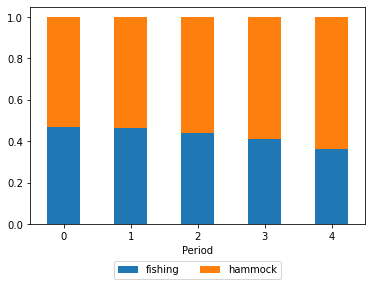

In [31]:
plot_choice_shares(data)

#### Extended Robinson Model

In [32]:
_, _, data = rp.get_example_model("robinson_crusoe_extended")

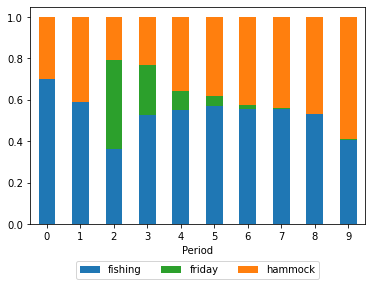

In [33]:
plot_choice_shares(data, friday=True)

### Keane and Wolpin (1994)

Aside from toy models, **respy** also provides several models that stem from the economic literature on dynamic life-cycle models. The most simple examples are a group of models based on the following publication:

- Keane, M. P., & Wolpin, K. I. (1994). The Solution and Estimation of Discrete Choice Dynamic Programming Models by Simulation and Interpolation: Monte Carlo Evidence. *The Review of Economics and Statistics*, 648-672.

The study is mainly concerned with the computational difficulties that accompany the solution of discrete choice dynamic programming (DCDP) problems such as the ones encountered in dynamic life-cycle models of educational and occupational choice. In the study, Keane and Wolpin (1994) develop an approximate solution method which consists of Monte Carlo integration with simulation and an interpolation approach to ease the computational burden of solving the DCDP model. They utilize one model with three different parametrizations to assess their solution method. This model and its three parametrizations are example models that are part of the **respy** interface. They are called:

- `kw_94_one`
- `kw_94_two`
- `kw_94_three`

The model consists of four mutually exclusive alternatives that individuals can choose in each period. Agents can either choose to work in one of two sectors `a` or `b`, invest in education, or stay home. The work alternatives award a wage and experience, while school only awards experience. In the home option, individuals gain neither a wage nor experience. The plot below shows the choice patterns for the three parametrizations. The model considers a time horizon of 40 periods.

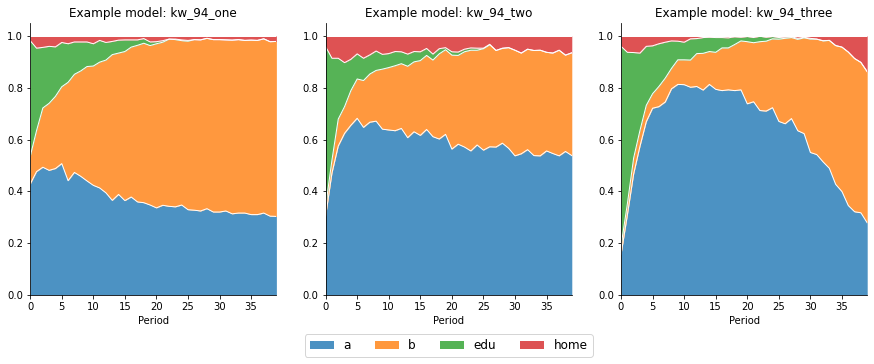

In [34]:
plot_choices_kw(example="1994")

### Keane and Wolpin (1997)

A more advanced group of examples are given by the models developed by Keane and Wolpin (1997). In this study, the authors implement an empirical structural life-cycle model of occupational choice and human capital investment. They estimate their models on data from the National Longitudinal Survey of Youth (NLSY).

* Keane, M. P., & Wolpin, K. I. (1997). The Career Decisions of Young Men. *Journal of Political Economy*, 105(3), 473-522.

**respy** supports both the basic and extended model from the paper. They are named:

- `kw_97_basic`
- `kw_97_extended`

However, the parametrization from the paper returns different life-cycle patterns for **respy** than presented in the paper. You can thus also access our estimates based for the models that are based on the same empirical data by adding `_respy` to the model name. 


The modelsnumber consists of three occupational choices (*white collar*, *blue collar*, and *military*), one educational choice (*school*), and a *home* option. Both models consider a life-cycle of 50 periods. These models are decidedly larger than the toy models explored in this tutorial and require a considerable amount of computation power to solve, especially the extended model. The estimated life-cycle patterns are shown below.


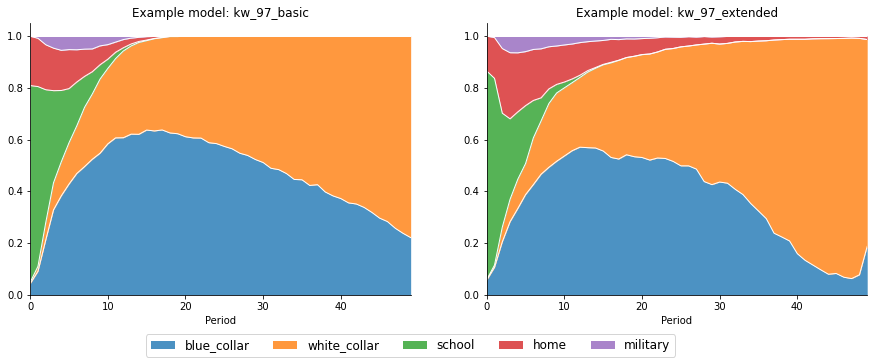

In [35]:
plot_choices_kw(example="1997")

#### How do the models compare to empirical data?

Below are the model predictions plotted against the observed choices. These plots correspond to Figure 1-5 (p.492-494) in the paper.  

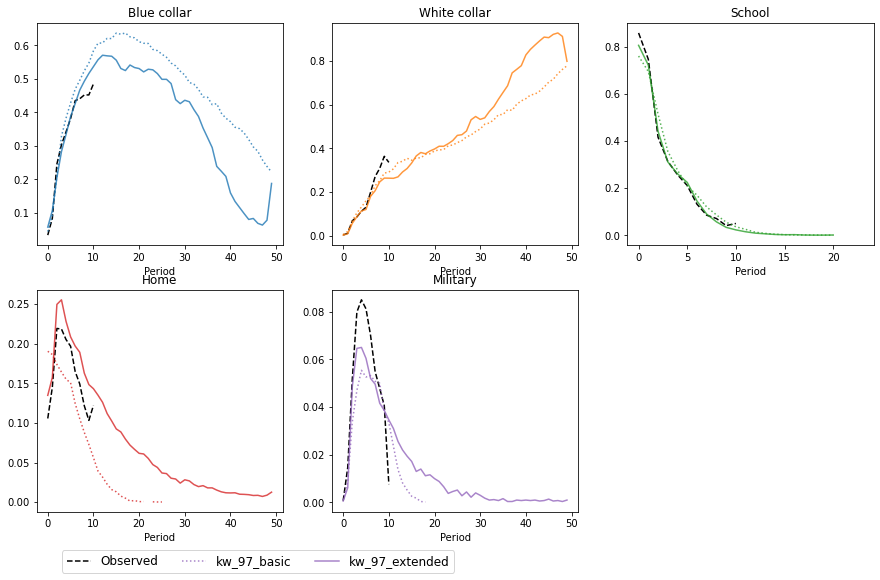

In [36]:
plot_kw_97_comparison()

### Keane and Wolpin (2000)

Another example model provided in the respy interface is the model presented in Keane and Wolpin (2000). The model incorporates an observable charactistic to account for race aiming to analyze the effects of monetary incentive schemes designed to reduce racial differences in school attainment and earnings.

- Keane, M. P., & Wolpin, K. I. (2000). Eliminating Race Differences in School Attainment and Labor Market Success. *Journal of Labor Economics*, 18(4), 614-652.

The model is named 

- `kw_2000`

The model is very similar to the extended model specification in Keane and Wolpin (1997).

<div class="alert alert-block alert-info">
    <u><h2>4. Further and upcoming functionalities in respy and other OpenSourceEconomics packages</h2></u>
</div>

As `respy` is an open source project multiple teams work on extensions of the existing flexibility. The next major advancements are:

- Exogenous processes (childbirth, health shocks etc.)

- Consumption and saving decision.
 
A very recent and big step for `respy` was the introduction of state specific choice sets. As documentation is still in development, there are not tutorials yet for every aspect. The current documentation can be found [here](https://respy.readthedocs.io/en/latest/).

Besides simulation of economic models, `respy` of course offers the possibility to estimate your model on data. Furthermore you have the option to fix certain parameters and only estimate others. For the estimation, the following techniques are available:

- Maximum likelihood estimation (ML)
- Method of simulated moments (MSM)

For both techniques you can find details in our [ekw-lectures](https://github.com/OpenSourceEconomics/ekw-lectures/tree/master/lectures).

Note that `respy`, does not have any optimizers implemented. For a set of given parameters `respy` creates the corresponding criterion function value. It is best optimized by the OpenSourceEconomics estimation package `estimagic`. Further examples of OSE software packages designed to interact with each other are:

- [`ruspy`](https://ruspy.readthedocs.io/en/latest/) is an open-source Python package for the simulation and estimation of a prototypical infinite-horizon dynamic discrete choice model based on Rust (1987).

- [`grmpy`](https://grmpy.readthedocs.io/en/latest/) is an open-source Python package for the simulation and estimation of the generalized Roy model.

- [`econsa`](https://econsa.readthedocs.io/en/latest/) is an open-source Python package that facilitates uncertainty propagation and global sensitivity of computational economic models.analysis.

- [`robupy`](https://robupy.readthedocs.io/en/latest/) is an open-source Python package for robust decision making.

- [`gettsim`](https://gettsim.readthedocs.io/en/stable/) is an open-source Python package developed by OSE members providing a depiction of the German Taxes and Transfers System.
 

Check out the OpenSourceEconomics homepage for more information on all packages https://open-econ.org.